# 인공지능

## 지도학습 : 문제와 정답을 알려주고 패턴 찾는 것
-  분류분석, 회귀분석
## 비지도학습 : 문제만 알려주고 알고리즘이 알아서 패턴 찾는 것
- 군집분석

# 분류 분석 대표적 알고리즘 : Tree  기반 모델

## 의사결정나무(Decision Tree)
- Decision Tree는 데이터를 분할하여 조건문처럼 분기해가며 예측하는 Tree 기반 모델
- 스무고개와 비슷하게 계속 질문을 던져서 분리

### 장점
- 직관적이고 해석 용이
- feature scaling(변수)이 필요 없음
- 범주형(DecisionTreeClassifier), 수치형(DecisionTreeRegressor) 자료 모두를 분석 가능

### 단점
- 과적합(overfitting)이 잘 일어남(test 데이터에만 fit하게 나타날 수 있음)
- 최적 트리를 찾기 어렵고 시간이 오래 걸릴 수 있음


0. 필요한 라이브러리 로딩
1. 타이타닉 데이터 로딩
2. 데이터 전처리(결측값처리, 이상값 탐지)
3. EDA(탐색적 데이터 분석, 각 컬럼의 데이터 분포, 그래프로 생성, 문자->숫자, 상관관계)
4. Feature Engineering(변수 선택, 새로운 특성 생성, 카테고리 변수와 더미 변수화(one-hot encoding))
5. 최종 선택된 변수를 독립변수(X)와 종속변수(y)로 분리
6. sklearn의 train_test_split을 불러와서 train, test 세트로 분리
7. sklearn에서 DecisionTreeClassifier를 불러와서 모델 훈련
8. test 세트를 모델에 넣어서 예측값 생성(pred)
9. accuracy_score(), classification_report()를 이용해서 모델의 성능 확인

# 0. 필요한 라이브러리 로딩

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.impute import SimpleImputer

# 1. 타이타닉 데이터 로딩

In [154]:
data = pd.read_csv('./data/Taitanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [155]:
# 데이터의 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [156]:
# 데이터의 기초 통계량 확인
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2. 데이터 전처리(결측값처리, 이상값 탐지)
- 5% 미만 : 행 단위 제거(분석에 큰 영향을 주지 않으므로 단순 제거)
- 5% 이상 30% 미만 : 결측치 대체
    - 수치형 데이터 : 평균, 중앙값, 최빈값(.mode)으로 대체 가능
    - 문자형 데이터 : 최빈값으로 대체 가능
- 30% 이상 50% 미만 : 컬럼의 중요도 판단 후 대체 또는 제거 진행(KNN Imputer,  회귀모델 기반 예측 등으로 판단)
- 50% 이상 : 해당 컬럼 삭제(데이터 손실이 크기 때문에 유의미한 결과를 나타낼 수 없음)

## 데이터 전처리(결측값처리)

In [157]:
# 결측치 차지 비율 확인
data.isna().sum() / len(data) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

### 데이터 결측치 존재 컬럼
- Age            19.865320 : 결측치 대체
-  Cabin          77.104377 : Cabin 컬럼 제거
-  Embarked        0.224467 : 행 단위로 제거하거나 대체

In [158]:
# Age 컬럼 결측치 대치
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [159]:
# 평균값 대치
data2 = data.copy()
na_idx = data2[data2['Age'].isna()].index
imp_mean = SimpleImputer(strategy='mean')

In [160]:
data['Age'] = imp_mean.fit_transform(data2[['Age']])[:, 0]
data.loc[na_idx]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,29.699118,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,29.699118,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,29.699118,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,29.699118,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,29.699118,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,29.699118,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,29.699118,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,29.699118,0,0,349217,7.8958,NaN,S


In [161]:
# Cabin 컬럼 제거
data = data.drop('Cabin', axis=1)

In [162]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [163]:
# Embarked는 최빈값 대체
data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [165]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode())[0]

In [168]:
# 결측치 존재하지 않는 최종 테이블 확인
print(data.isna().sum())
data

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,S


## 데이터 전처리(이상값 탐지)

<Axes: >

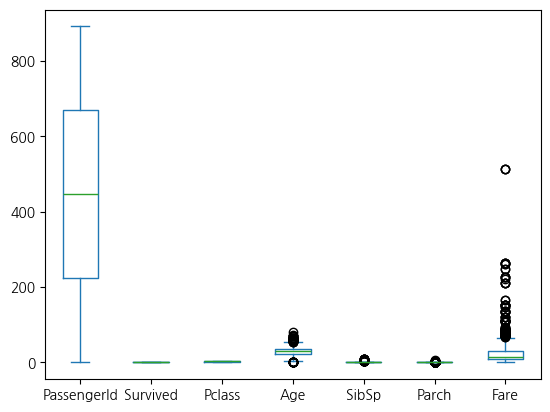

In [180]:
# 전체 컬럼에 대해 숫자형 자료에 대해 박스 플롯 확인
data_num = data[data.describe().columns]
data_num.plot(kind='box')

889


<Axes: >

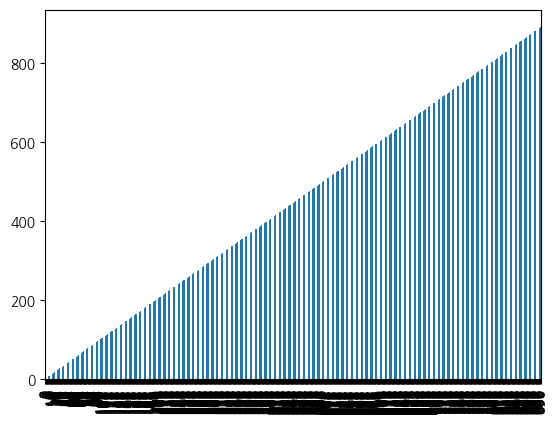

In [63]:
# PassengerId 확인
# unique 값 확인
print(len(data['PassengerId'].unique()))

# 인덱스와 같이 작용 
# 이상치는 없는 것으로 판단
data['PassengerId'].plot(kind='bar')

[0 1]
Survived
0    549
1    340
Name: count, dtype: int64


<Axes: ylabel='count'>

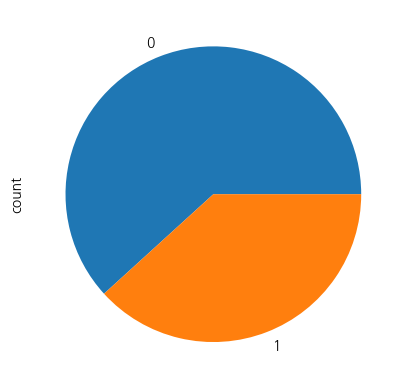

In [106]:
# Survived 확인
# uqnique값 확인
print(data['Survived'].unique())
print(data['Survived'].value_counts())

# 파이 그래프 생성
# 이상치는 없는 것으로 판단
data['Survived'].value_counts().plot(kind='pie')


[3 1 2]
Pclass
3    491
1    214
2    184
Name: count, dtype: int64


<Axes: xlabel='Pclass'>

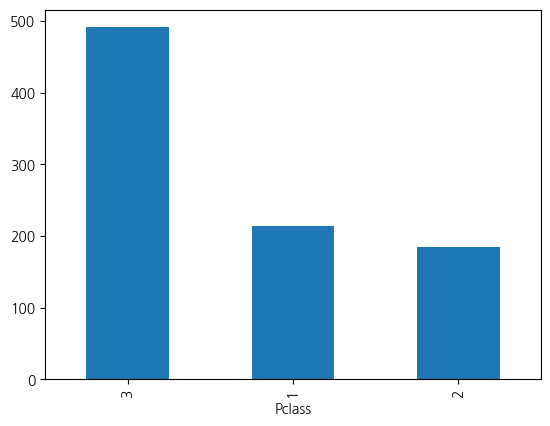

In [78]:
# Pclass 확인
# uqnique값 확인
print(data['Pclass'].unique())
print(data['Pclass'].value_counts())

# 막대 그래프 생성
# 이상치는 없는 것으로 판단
data['Pclass'].value_counts().plot(kind='bar')


In [77]:
# Name 확인
# uqnique값 확인
# 이상치 없는 것으로 판단
print(len(data['Name'].unique()))
print(data['Name'].value_counts())

889
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
O'Dwyer, Miss. Ellen "Nellie"                          1
Todoroff, Mr. Lalio                                    1
Uruchurtu, Don. Manuel E                               1
Spencer, Mrs. William Augustus (Marie Eugenie)         1
Glynn, Miss. Mary Agatha                               1
Name: count, Length: 889, dtype: int64


Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
24.500000      1
0.670000       1
0.420000       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64


(array([0.01272146, 0.00593668, 0.00424049, 0.00593668, 0.00127215,
        0.01229741, 0.01653789, 0.02756315, 0.03095554, 0.01781004,
        0.02756315, 0.1013476 , 0.0139936 , 0.01993028, 0.0156898 ,
        0.00890502, 0.01187336, 0.00890502, 0.00678478, 0.00593668,
        0.00636073, 0.00296834, 0.00381644, 0.00296834, 0.00169619,
        0.        , 0.00212024, 0.00042405, 0.        , 0.00042405]),
 array([ 0.42      ,  3.07266667,  5.72533333,  8.378     , 11.03066667,
        13.68333333, 16.336     , 18.98866667, 21.64133333, 24.294     ,
        26.94666667, 29.59933333, 32.252     , 34.90466667, 37.55733333,
        40.21      , 42.86266667, 45.51533333, 48.168     , 50.82066667,
        53.47333333, 56.126     , 58.77866667, 61.43133333, 64.084     ,
        66.73666667, 69.38933333, 72.042     , 74.69466667, 77.34733333,
        80.        ]),
 <BarContainer object of 30 artists>)

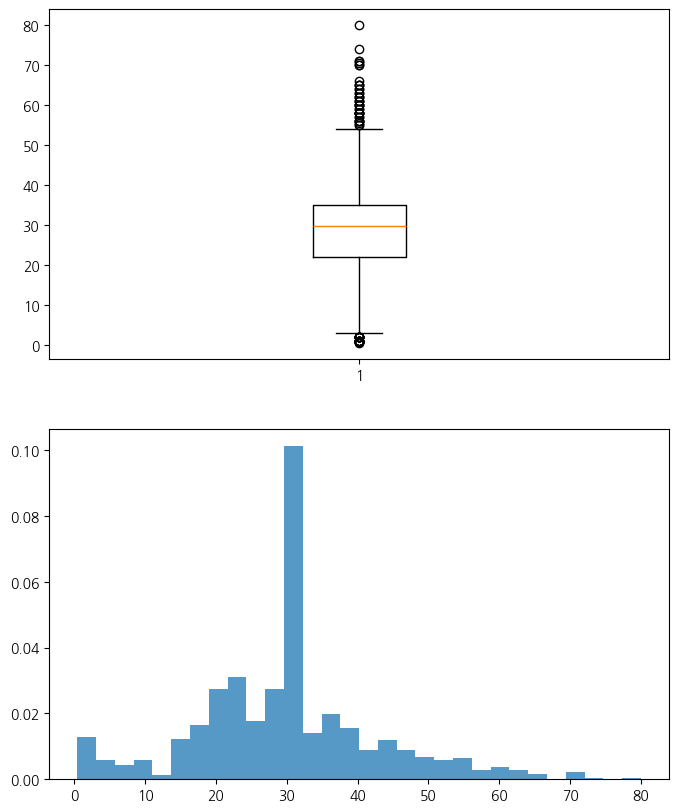

In [114]:
# Age 확인
# uqnique값 확인
# print(data['Age'].unique())
print(data['Age'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Age'], vert=True)
axes[1].hist(data['Age'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

[1 0 3 4 2 5 8]
SibSp
0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64


(array([2.55624297, 0.        , 0.        , 0.88160855, 0.        ,
        0.        , 0.        , 0.11811024, 0.        , 0.        ,
        0.        , 0.06749156, 0.        , 0.        , 0.        ,
        0.07592801, 0.        , 0.        , 0.02109111, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.02952756]),
 array([0.        , 0.26666667, 0.53333333, 0.8       , 1.06666667,
        1.33333333, 1.6       , 1.86666667, 2.13333333, 2.4       ,
        2.66666667, 2.93333333, 3.2       , 3.46666667, 3.73333333,
        4.        , 4.26666667, 4.53333333, 4.8       , 5.06666667,
        5.33333333, 5.6       , 5.86666667, 6.13333333, 6.4       ,
        6.66666667, 6.93333333, 7.2       , 7.46666667, 7.73333333,
        8.        ]),
 <BarContainer object of 30 artists>)

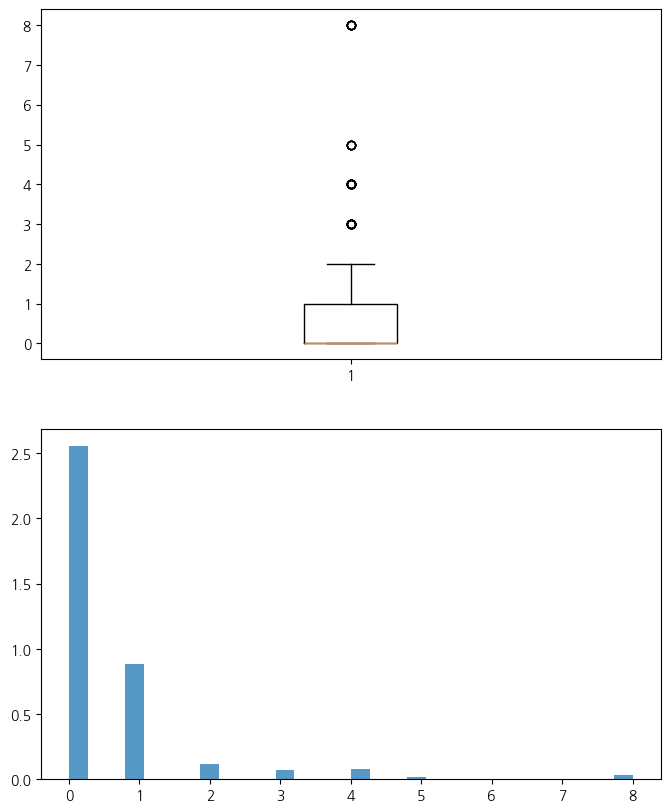

In [147]:
# SibSp(형제자매 수)확인
# uqnique값 확인
print(data['SibSp'].unique())
print(data['SibSp'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['SibSp'], vert=True)
axes[1].hist(data['SibSp'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

[0 1 2 5 3 4 6]
Parch
0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


(array([3.80202475, 0.        , 0.        , 0.        , 0.        ,
        0.66366704, 0.        , 0.        , 0.        , 0.        ,
        0.44994376, 0.        , 0.        , 0.        , 0.        ,
        0.02812148, 0.        , 0.        , 0.        , 0.        ,
        0.02249719, 0.        , 0.        , 0.        , 0.        ,
        0.02812148, 0.        , 0.        , 0.        , 0.0056243 ]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. ]),
 <BarContainer object of 30 artists>)

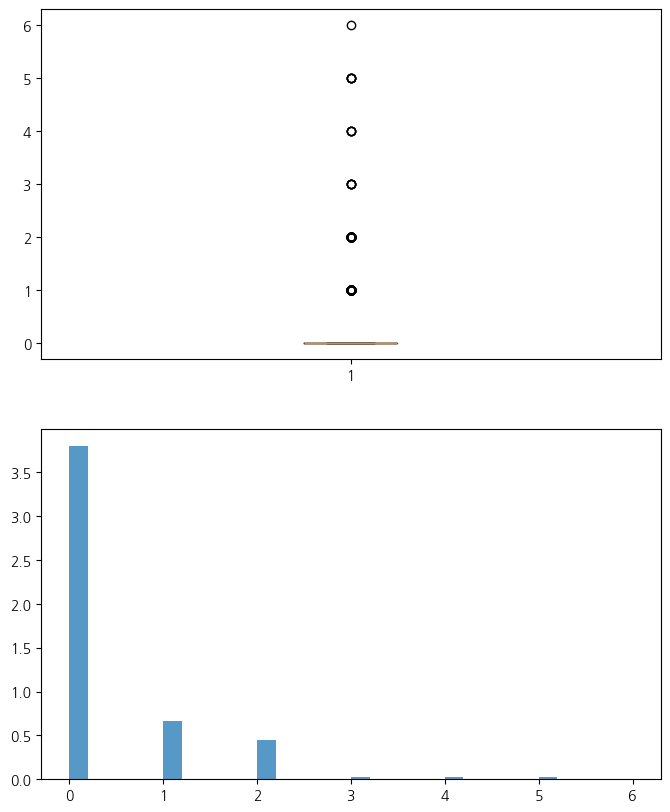

In [148]:
# Parch(부모/자식 수)확인
# uqnique값 확인
print(data['Parch'].unique())
print(data['Parch'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Parch'], vert=True)
axes[1].hist(data['Parch'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)

Ticket
347082             7
1601               7
CA. 2343           7
CA 2144            6
347088             6
                  ..
SOTON/OQ 392076    1
211536             1
112053             1
111369             1
7546               1
Name: count, Length: 680, dtype: int64


<Axes: xlabel='Ticket'>

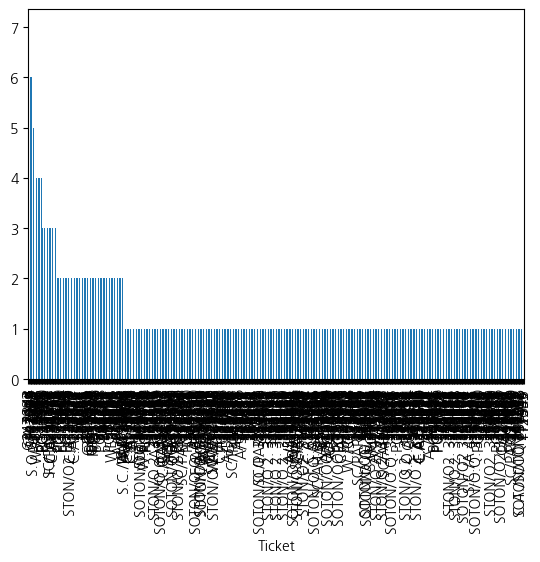

In [141]:
# Ticket 확인
# uqnique값 확인
# print(data['Ticket'].unique())
print(data['Ticket'].value_counts())

# 막대그래프 생성
data['Ticket'].value_counts().plot(kind='bar')

Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
13.8583     1
50.4958     1
5.0000      1
9.8458      1
10.5167     1
Name: count, Length: 247, dtype: int64


(array([0.03267022, 0.01258067, 0.00296403, 0.00296403, 0.0030299 ,
        0.00085628, 0.00072454, 0.00072454, 0.00059281, 0.00013173,
        0.        , 0.        , 0.00032934, 0.00026347, 0.00013173,
        0.0003952 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0001976 ]),
 array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
        102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
        204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
        307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
        409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
        512.3292 ]),
 <BarContainer object of 30 artists>)

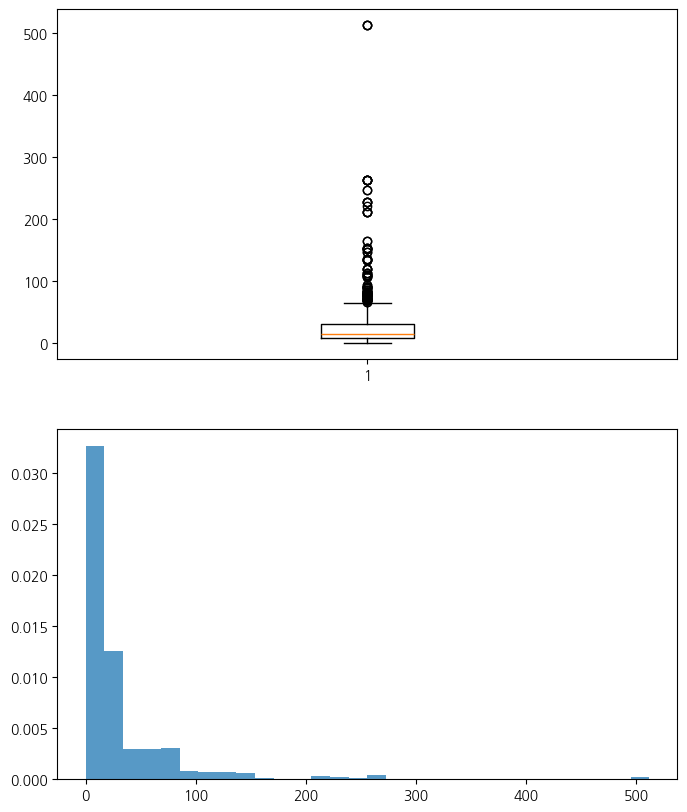

In [146]:
# Fare 확인
# uqnique값 확인
# print(data['Fare'].unique())
print(data['Fare'].value_counts())

# 박스 플롯 그래프, 히스토그램 생성
# 이상치 존재
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].boxplot(data['Fare'], vert=True)
axes[1].hist(data['Fare'], bins=30, density=True, 
             facecolor='C0', alpha=0.75)